# loading thermal data

In [2]:
#cleanign the dataset by removing infinite values of insulation efficiency which was generated mostly for thin slab

import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('processed_thermal_data.csv')

# Replace Inf and NaN in 'Insulation_Efficiency'
data['Insulation_Efficiency'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where Insulation_Efficiency is NaN (caused by division by zero)
data.dropna(subset=['Insulation_Efficiency'], inplace=True)

# Save cleaned dataset
data.to_csv('cleaned_thermal_data.csv', index=False)
print("✅ Cleaned dataset saved as 'cleaned_thermal_data.csv'")


✅ Cleaned dataset saved as 'cleaned_thermal_data.csv'




Outliers in dT_dt can skew regression models, affecting accuracy.

In [3]:
# Define outlier threshold (e.g., within ±3 standard deviations)
threshold = 3 * data['dT_dt'].std()
mean_dT_dt = data['dT_dt'].mean()

# Remove extreme outliers
data = data[(data['dT_dt'] > mean_dT_dt - threshold) & (data['dT_dt'] < mean_dT_dt + threshold)]

# Save cleaned dataset
data.to_csv('cleaned_thermal_data.csv', index=False)
print("✅ Outliers in dT_dt removed and dataset saved again.")

✅ Outliers in dT_dt removed and dataset saved again.


Feature Selection We now select the most relevant features for machine learning

In [5]:
# Select relevant features
selected_features = ['Thickness', 'Fourier_Number', 'Temp_Diff', 'Insulation_Efficiency']
selected_data = data[selected_features]

# Save reduced dataset
selected_data.to_csv('selected_features_data.csv', index=False)
print("✅ Feature selection complete: Saved as 'selected_features_data.csv'")

from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Normalize Thickness, Fourier Number, Temp_Diff
selected_data[['Thickness', 'Fourier_Number', 'Temp_Diff']] = scaler.fit_transform(selected_data[['Thickness', 'Fourier_Number', 'Temp_Diff']])

# Save the normalized dataset
selected_data.to_csv('normalized_features_data.csv', index=False)
print("✅ Normalized dataset saved as 'normalized_features_data.csv'")

✅ Feature selection complete: Saved as 'selected_features_data.csv'
✅ Normalized dataset saved as 'normalized_features_data.csv'


C:\Users\kawri\AppData\Local\Temp\ipykernel_26708\2529985900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[['Thickness', 'Fourier_Number', 'Temp_Diff']] = scaler.fit_transform(selected_data[['Thickness', 'Fourier_Number', 'Temp_Diff']])


Ensures ML models treat all features equally and prevents bias from large values

Recheck Data Statistics Finally, let's verify if the data is clean and ready for ML.

Interpretation:

Features with high correlation (>0.9) are redundant and should be removed.

In [6]:
# Load and summarize
cleaned_data = pd.read_csv('normalized_features_data.csv')
print(cleaned_data.describe())

         Thickness  Fourier_Number    Temp_Diff  Insulation_Efficiency
count  4591.000000     4591.000000  4591.000000           4.591000e+03
mean      0.521455        0.047280     0.261020           8.427555e+07
std       0.302561        0.123291     0.229896           2.639810e+09
min       0.000000        0.000000     0.000000          -1.964610e+10
25%       0.272727        0.004437     0.039530           2.805123e-02
50%       0.545455        0.009760     0.251232           7.556357e-02
75%       0.818182        0.030058     0.351743           3.783995e-01
max       1.000000        1.000000     1.000000           9.987822e+10


Step-by-Step Fixes and Data Cleaning We will fix these issues before proceeding to machine learning.

🔹 Step 1: Clip Extreme Insulation_Efficiency Values Since Insulation_Efficiency has extreme positive and negative values, we clip it to a reasonable range.

In [7]:
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv('normalized_features_data.csv')

# Define reasonable limits (99th percentile for upper limit, 1st percentile for lower limit)
lower_limit = data['Insulation_Efficiency'].quantile(0.01)  # 1st percentile
upper_limit = data['Insulation_Efficiency'].quantile(0.99)  # 99th percentile

# Clip values within this range
data['Insulation_Efficiency'] = np.clip(data['Insulation_Efficiency'], lower_limit, upper_limit)

# Save fixed dataset
data.to_csv('clipped_features_data.csv', index=False)
print("✅ Clipped extreme values in Insulation Efficiency and saved as 'clipped_features_data.csv'")

✅ Clipped extreme values in Insulation Efficiency and saved as 'clipped_features_data.csv'


It Prevents extreme values from distorting the model. Ensures robust ML training.

In [8]:
# Replace 0 values with a small number which Prevents division errors
small_value = 1e-5
data['Temp_Diff'] = data['Temp_Diff'].replace(0, small_value)
data['Fourier_Number'] = data['Fourier_Number'].replace(0, small_value)

# Save updated dataset
data.to_csv('final_cleaned_data.csv', index=False)
print("✅ Replaced 0 values and saved as 'final_cleaned_data.csv'")

✅ Replaced 0 values and saved as 'final_cleaned_data.csv'


Recheck Data Statistics Finally, let’s verify the cleaned dataset.

In [10]:
# Load and summarize
cleaned_data = pd.read_csv('final_cleaned_data.csv')
print(cleaned_data.describe())

         Thickness  Fourier_Number    Temp_Diff  Insulation_Efficiency
count  4591.000000     4591.000000  4591.000000           4.591000e+03
mean      0.521455        0.047280     0.261020           2.525351e+06
std       0.302561        0.123291     0.229896           2.181967e+07
min       0.000000        0.000003     0.000010           2.637520e-03
25%       0.272727        0.004437     0.039530           2.805123e-02
50%       0.545455        0.009760     0.251232           7.556357e-02
75%       0.818182        0.030058     0.351743           3.783995e-01
max       1.000000        1.000000     1.000000           2.082329e+08


Final Step: Apply Log Transformation to Insulation_Efficiency Since Insulation_Efficiency spans several orders of magnitude, applying a logarithmic transformation will improve model performance.

In [11]:
import numpy as np
import pandas as pd

# Load the cleaned dataset
data = pd.read_csv('final_cleaned_data.csv')

# Apply log transformation (adding a small constant to avoid log(0))
data['Insulation_Efficiency'] = np.log1p(data['Insulation_Efficiency'])  # log1p(x) = log(x+1) to handle small values

# Save final dataset
data.to_csv('final_ml_ready_data.csv', index=False)
print("✅ Log-transformed Insulation Efficiency and saved as 'final_ml_ready_data.csv'")

✅ Log-transformed Insulation Efficiency and saved as 'final_ml_ready_data.csv'


Log Transform Reduces huge variation in scale. Improves linear model performance. Prevents extreme values from dominating predictions.

In [12]:
# Load and summarize
cleaned_data = pd.read_csv('final_ml_ready_data.csv')
print(cleaned_data.describe())

         Thickness  Fourier_Number    Temp_Diff  Insulation_Efficiency
count  4591.000000     4591.000000  4591.000000            4591.000000
mean      0.521455        0.047280     0.261020               1.197414
std       0.302561        0.123291     0.229896               3.153044
min       0.000000        0.000003     0.000010               0.002634
25%       0.272727        0.004437     0.039530               0.027665
50%       0.545455        0.009760     0.251232               0.072845
75%       0.818182        0.030058     0.351743               0.320923
max       1.000000        1.000000     1.000000              19.154168


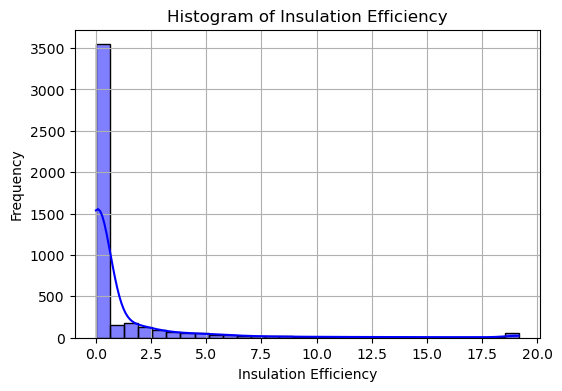

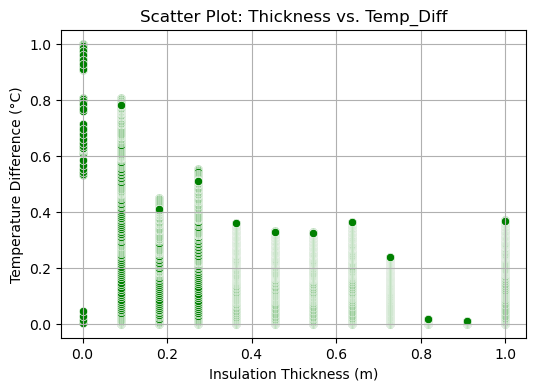

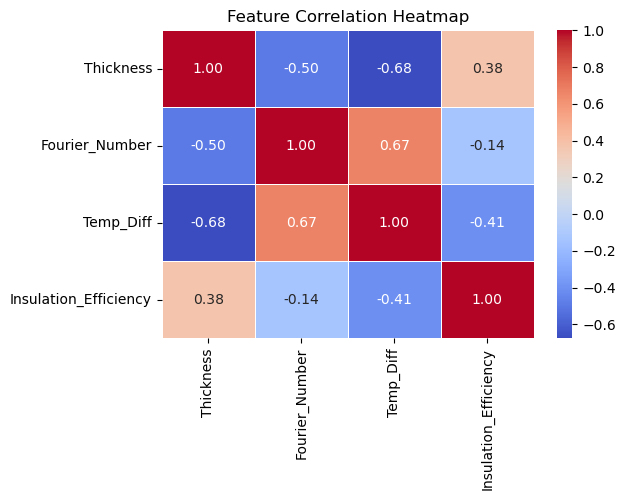

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('final_ml_ready_data.csv')

# 🔹 FIGURE 1: Histogram of Insulation Efficiency
plt.figure(figsize=(6,4))
sns.histplot(data['Insulation_Efficiency'], bins=30, kde=True, color='blue')
plt.xlabel('Insulation Efficiency')
plt.ylabel('Frequency')
plt.title('Histogram of Insulation Efficiency')
plt.grid(True)
plt.show()

# 🔹 FIGURE 2: Scatter Plot - Thickness vs. Temp_Diff
plt.figure(figsize=(6,4))
sns.scatterplot(x=data['Thickness'], y=data['Temp_Diff'], color='green')
plt.xlabel('Insulation Thickness (m)')
plt.ylabel('Temperature Difference (°C)')
plt.title('Scatter Plot: Thickness vs. Temp_Diff')
plt.grid(True)
plt.show()

# 🔹 FIGURE 3: Correlation Heatmap
plt.figure(figsize=(6,4))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


Feature Relationship Analysis We will now visualize important feature interactions.

(a) Thickness vs. Temperature Difference

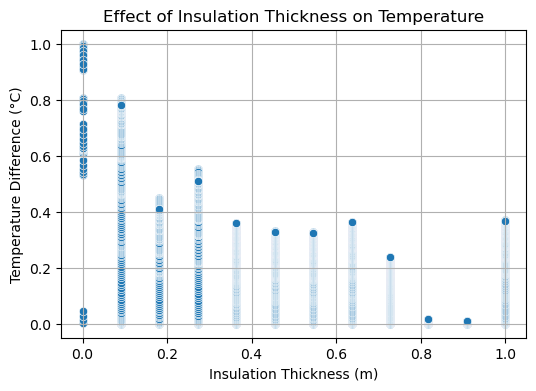

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=data['Thickness'], y=data['Temp_Diff'])
plt.xlabel('Insulation Thickness (m)')
plt.ylabel('Temperature Difference (°C)')
plt.title('Effect of Insulation Thickness on Temperature')
plt.grid(True)
plt.show()

(b) Fourier Number vs. Temperature Difference

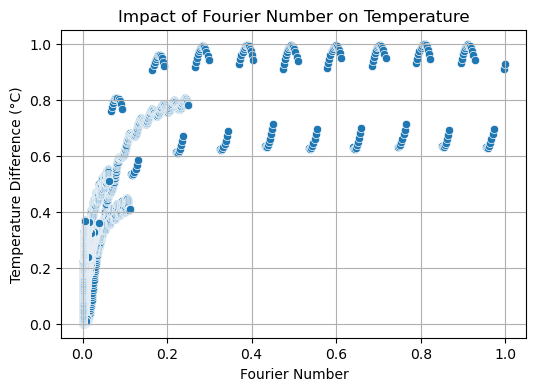

In [16]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=data['Fourier_Number'], y=data['Temp_Diff'])
plt.xlabel('Fourier Number')
plt.ylabel('Temperature Difference (°C)')
plt.title('Impact of Fourier Number on Temperature')
plt.grid(True)
plt.show()


Expected Insight:

Fourier Number indicates the rate of thermal diffusion.

(c) Insulation Efficiency vs. Thickness

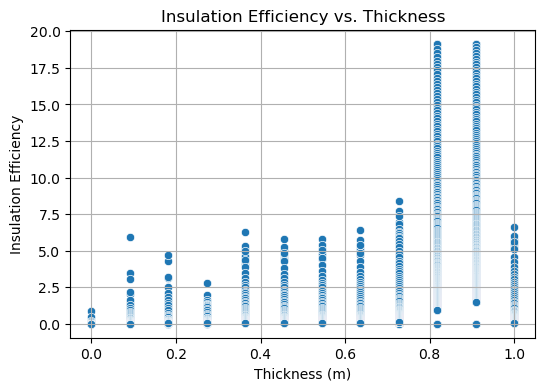

In [17]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=data['Thickness'], y=data['Insulation_Efficiency'])
plt.xlabel('Thickness (m)')
plt.ylabel('Insulation Efficiency')
plt.title('Insulation Efficiency vs. Thickness')
plt.grid(True)
plt.show()

If efficiency plateaus at higher thicknesses, additional insulation may not be effective.

# Extended Data

In [19]:
#Load and process extended Simulation Data
import pandas as pd
import numpy as np

# Load the new simulation data
df = pd.read_csv('extended_thermal_data.csv')

# Basic sanity check
print(df.head())
print(df['Profile'].value_counts())  # Confirm all 3 profiles are present

   Thickness       Time  Outer_Temperature Profile
0       0.01   0.000000          20.000000     sin
1       0.01   7.518797          20.007401     sin
2       0.01  15.037594          20.015947     sin
3       0.01  22.556391          20.047089     sin
4       0.01  30.075188          20.099021     sin
Profile
sin     8000
cos     8000
step    8000
Name: count, dtype: int64


Feature Engineering¶
Add engineered features like Temp_Diff, Fourier Number, and Efficiency:

In [20]:
# Add Temp_Diff assuming inner temp is 20°C
df['Temp_Diff'] = df['Outer_Temperature'] - 20

# Thermal properties (same as MATLAB)
k = 0.5
rho = 900
cp = 2500

# Compute Fourier Number
df['Fourier_Number'] = (k * df['Time']) / (rho * cp * df['Thickness']**2)

# Compute Insulation Efficiency (with small epsilon to avoid div by zero)
epsilon = 1e-6
df['Insulation_Efficiency'] = df['Thickness'] / (df['Temp_Diff'] + epsilon)

# Drop any rows with invalid values (e.g., from numerical noise)
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Normalize and Apply PCA

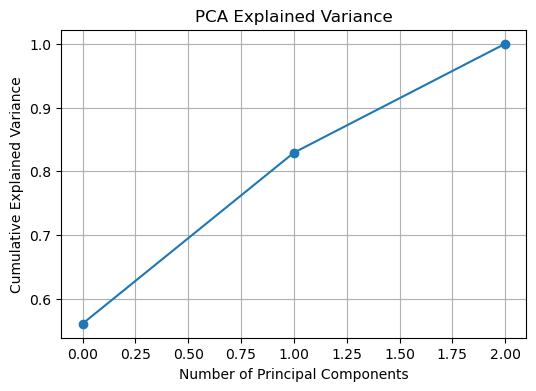

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select relevant features
features = ['Thickness', 'Fourier_Number', 'Temp_Diff']
X = df[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Append PCA results to DataFrame
df_pca = df.copy()
df_pca[['PC1', 'PC2', 'PC3']] = X_pca